<a href="https://colab.research.google.com/github/unasthana/ImageGenAnalysis/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary Imports

import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms

from NonSyntheticGeneration import NonSyntheticDataset
from ClassifierNetwork import ResNet18, ResBlock, NetTrain, NetTest
from Utils import plot_metrics, make_classification_report, plot_confusion_matrix

In [2]:
# Global Constants

SEED = 42
BATCH_SIZE = 128
EPOCHS = 50

CIFAR_10_MEANS = (0.4914, 0.4822, 0.4465)
CIFAR_10_STDS = (0.2023, 0.1994, 0.2010)

PATH = "/content/models"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Setting Seeds for Reproducibility

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Part - I: Generating Non-Synthetic Dataset (Train/Test) 


train_transform = transforms.Compose([transforms.RandomCrop(32,
                                                            padding = 4),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(), 
                          transforms.Normalize(CIFAR_10_MEANS,
                                               CIFAR_10_STDS)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(CIFAR_10_MEANS,
                                                          CIFAR_10_STDS)])

trainset = NonSyntheticDataset(root = './data', train = True, 
                               transform = train_transform,
                               download = True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True, 
                                          num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

testset = torchvision.datasets.CIFAR10(root = './data', train = False, 
                                       download = True, 
                                       transform = test_transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle = False, 
                                         num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Defining function to initialize the neural network

def init_network():

  criterion = nn.CrossEntropyLoss()

  net = ResNet18(3, ResBlock, outputs = 10)
  net.to(DEVICE) 

  optimizer = optim.SGD(net.parameters(), lr = 0.2, momentum = 0.0005, 
                        weight_decay = 5e-4)
    
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max = EPOCHS)

  return net, criterion, optimizer, scheduler 

In [6]:
# Creating directory to store the model weights for different generation 
# techniques

try: 
  os.mkdir(PATH)

except OSError as error: 
  print(error)

[Errno 17] File exists: '/content/models'


In [7]:
# Initializing ResNet18 for Non - Synthetic Generation

net, criterion, optimizer, scheduler = init_network()

In [8]:
# Training the ResNet18 for Non - Synthetic Generation

best_acc = 0
best_epoch = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  print(f'Epoch {epoch + 1} :')

  train_loss, train_acc = NetTrain(net, trainloader, DEVICE, optimizer, 
                                criterion)
  
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  print("Train Loss = " + str(train_loss) + "\t" + "Train Accuracy = " + 
        str(train_acc))

  test_loss , test_acc, predictions, labels = NetTest(net, testloader,
                                                      DEVICE, criterion)
  
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  
  print("Test Loss = " + str(test_loss) + "\t" + "Test Accuracy = " + 
        str(test_acc))


  if test_acc > best_acc:
    best_acc = test_acc
    best_epoch = epoch

    torch.save(net.state_dict(), 
               '/content/models/resnet_non_synthetic.pt')
  
  print("Best Test Accuracy = " + str(best_acc) + "\n")
  scheduler.step()

Epoch 1 :
Train Loss = 1.5874831639897182	Train Accuracy = 42.16
Test Loss = 4.011927828004088	Test Accuracy = 31.73
Best Test Accuracy = 31.73

Epoch 2 :
Train Loss = 1.0696594881279695	Train Accuracy = 61.658
Test Loss = 1.9053977682620664	Test Accuracy = 53.1
Best Test Accuracy = 53.1

Epoch 3 :
Train Loss = 0.7750429238199883	Train Accuracy = 72.95
Test Loss = 1.7607222463511214	Test Accuracy = 60.73
Best Test Accuracy = 60.73

Epoch 4 :
Train Loss = 0.5925633549842688	Train Accuracy = 79.752
Test Loss = 1.4893375091914889	Test Accuracy = 66.84
Best Test Accuracy = 66.84

Epoch 5 :
Train Loss = 0.49393752987122597	Train Accuracy = 83.048
Test Loss = 1.4864027168177352	Test Accuracy = 64.84
Best Test Accuracy = 66.84

Epoch 6 :
Train Loss = 0.4352511525001672	Train Accuracy = 85.008
Test Loss = 1.1076176875754247	Test Accuracy = 72.5
Best Test Accuracy = 72.5

Epoch 7 :
Train Loss = 0.3823819038508188	Train Accuracy = 86.934
Test Loss = 1.162488190433647	Test Accuracy = 75.87
Best T

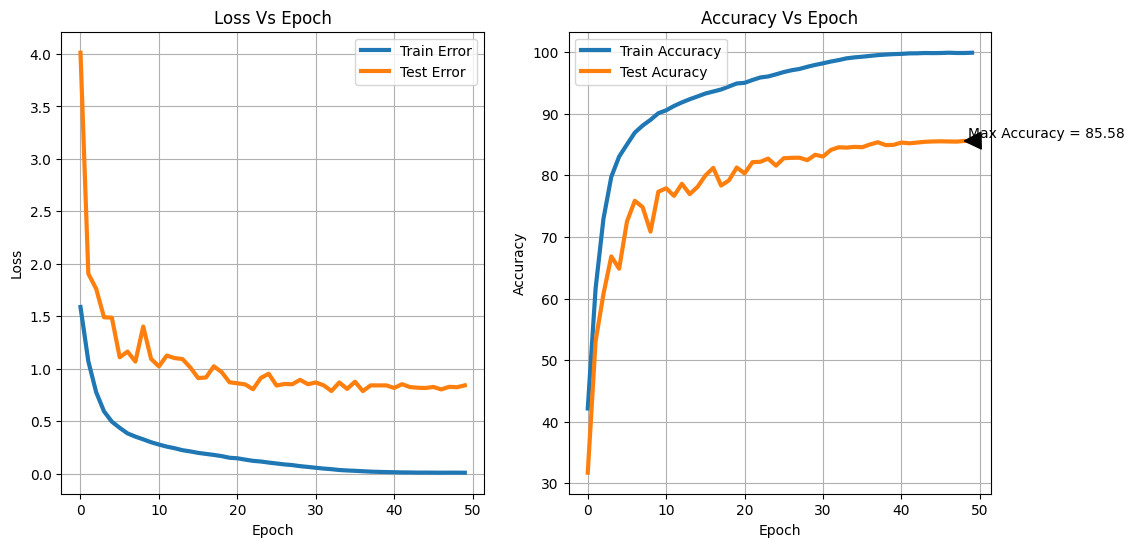

In [9]:
# Plotting Losses and Accuracies for Non - Synthetic Generation 

plot_metrics(train_accs, test_accs, train_losses, test_losses, best_epoch, best_acc)

In [10]:
# Making Classification Report 

net, criterion, optimizer, scheduler = init_network()
net.load_state_dict(torch.load('/content/models/resnet_non_synthetic.pt'))

test_loss , test_acc, predictions, labels = NetTest(net, testloader, DEVICE, criterion)

print(make_classification_report(labels, predictions, target_names = testset.classes))

              precision    recall  f1-score   support

    airplane       0.91      0.94      0.92      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.84      0.90      0.87      1000
         cat       1.00      0.04      0.08      1000
        deer       0.87      0.94      0.90      1000
         dog       0.60      0.94      0.73      1000
        frog       0.85      0.96      0.90      1000
       horse       0.92      0.95      0.93      1000
        ship       0.95      0.96      0.95      1000
       truck       0.95      0.96      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.88      0.86      0.82     10000
weighted avg       0.88      0.86      0.82     10000



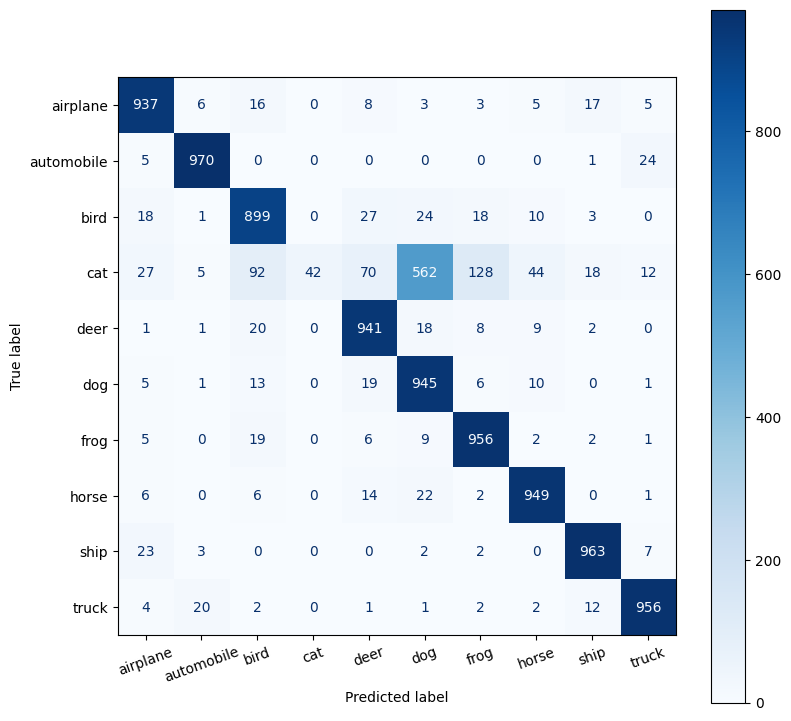

In [11]:
# Plotting Confusion Matrix

plot_confusion_matrix(labels, predictions, testset.classes)